In [142]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys, os
import pandas as pd
import sys
import datetime
import numpy
import numpy as np 
import scipy as sc
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import KFold,cross_val_score, learning_curve
from sklearn.feature_selection import RFE, RFECV
from sklearn.grid_search import GridSearchCV  

import xgboost as xgb

In [2]:
df = pd.concat(map(pd.read_csv, ['football_data.csv']),ignore_index=True,sort = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 30 columns):
AF               1849 non-null object
AGD              1900 non-null float64
AGL              1900 non-null float64
AGS              1900 non-null float64
ALF              1900 non-null float64
AOD              1900 non-null float64
AP               1900 non-null float64
AwayTeam         1900 non-null object
DOD              1900 non-null float64
DP               1900 non-null float64
DPB              1900 non-null float64
Day              1900 non-null int64
DaysFromToday    1900 non-null int64
FTR              1900 non-null object
GD               1900 non-null float64
HF               1849 non-null object
HGD              1900 non-null float64
HGL              1900 non-null float64
HGS              1900 non-null float64
HLF              1900 non-null float64
HOD              1900 non-null float64
HP               1900 non-null float64
HomeTeam         1900 non-null object
LFD  

In [3]:
def ent(data):
    p_data= data.value_counts()/len(data)
    entropy=sc.stats.entropy(p_data)
    return entropy

In [4]:
#Czy entropia ma zwiazek z korelacja ??
col = ['AF','AGD','AGL','AGS','ALF','AOD','AP','AwayTeam','DOD','DP','DPB','Day','DaysFromToday',
       'GD','HF','HGD','HGL','HGS','HLF','HOD','HP','HomeTeam','LFD','LSTPA','LSTPD','LSTPH','MW','Month','Year']
for column in col:
    print (column+':')
    print (ent(df[column]))

AF:
5.4637128749066965
AGD:
4.034538120028026
AGL:
4.076947202541234
AGS:
4.120178258670849
ALF:
1.101594198615197
AOD:
5.583542197296875
AP:
4.127395006248317
AwayTeam:
3.214025432660123
DOD:
4.9272143445038825
DP:
3.9963022264057675
DPB:
1.9810508264132523
Day:
3.411488443979931
DaysFromToday:
5.028834887303477
GD:
4.375121010889942
HF:
5.452259711268861
HGD:
4.033415363722988
HGL:
4.07073187556612
HGS:
4.115141849299441
HLF:
1.1583623863703438
HOD:
4.9507078838772856
HP:
4.138017477518469
HomeTeam:
3.214025432660123
LFD:
1.7151038963213336
LSTPA:
2.830940430253775
LSTPD:
3.5334379243833016
LSTPH:
2.830940430253775
MW:
3.6375861597263865
Month:
2.2795702675164633
Year:
1.7403156218734193


In [5]:
def code_string_values(df):
    team_code = df.AwayTeam.unique()
    team_code = dict(zip(team_code, range(len(team_code))))
    df = df.applymap(lambda s: team_code.get(s) if s in team_code else s)    
    
    form_code = df.HF.unique()
    form_code2 = df.AF.unique()
    form_code = numpy.concatenate((form_code, form_code2))
    
    form_code= dict(zip(form_code, range(len(form_code))))
    
    to_code = df.copy()
    to_code = to_code.applymap(lambda s: form_code.get(s) if s in form_code else s)
    
    df['HF'] = to_code['HF']
    df['AF'] = to_code['AF']

    return df

df = code_string_values(df)

In [7]:
def code_FTR(df):
    result_code = df.FTR.unique()
    result_code = dict(zip(result_code, range(len(result_code))))
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

In [11]:
df_copy = df.copy()
df_copy = code_FTR(df_copy) 

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

for c in range(5):
    print("ziarno ",c)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=c)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
    print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

ziarno  0
Accuracy of logistic regression classifier on train set: 0.5429
Accuracy of logistic regression classifier on test set: 0.5474
ziarno  1
Accuracy of logistic regression classifier on train set: 0.5586
Accuracy of logistic regression classifier on test set: 0.5211
ziarno  2
Accuracy of logistic regression classifier on train set: 0.5376
Accuracy of logistic regression classifier on test set: 0.5561
ziarno  3
Accuracy of logistic regression classifier on train set: 0.5571
Accuracy of logistic regression classifier on test set: 0.5123
ziarno  4
Accuracy of logistic regression classifier on train set: 0.5534
Accuracy of logistic regression classifier on test set: 0.5211


In [31]:
df_copy = df.copy()
df_copy = code_FTR(df_copy) 

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

classifier = LogisticRegression()

scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

LogisticRegression average accuracy is 0.530


In [34]:
def normalize(df):
    colums_to_normalization = ['AF','AGD','AGL','AGS','ALF','AOD','AP','DOD','DP','DPB','Day','DaysFromToday',
       'GD','HF','HGD','HGL','HGS','HLF','HOD','HP','LFD','LSTPA','LSTPD','LSTPH','MW','Month','Year']
    df[colums_to_normalization] = df[colums_to_normalization].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
    return df

In [35]:
df_copy = df.copy()
df_copy = code_FTR(df_copy) 
df_copy = normalize(df_copy)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

classifier = LogisticRegression()
scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

LogisticRegression average accuracy is 0.529


In [36]:
col = ['AF','AGD','AGL','AGS','ALF','AOD','AP','AwayTeam','DOD','DP','DPB','Day','DaysFromToday',
       'GD','HF','HGD','HGL','HGS','HLF','HOD','HP','HomeTeam','LFD','LSTPA','LSTPD','LSTPH','MW','Month','Year']
for c in col:
    print(c)
    print(df['FTR'].corr(df[c],method='spearman'))

AF
0.0024375491823891296
AGD
-0.2542298759134714
AGL
0.12058728582328944
AGS
-0.070180333373741
ALF
-0.12140291670995883
AOD
0.07546299887956254
AP
-0.07258832027993237
AwayTeam
0.10178349237191826
DOD
0.010929363473138562
DP
0.3359437632025874
DPB
0.21297806331652908
Day
-0.02743209232605637
DaysFromToday
-0.0424970529961861
GD
0.3473920593136676
HF
-0.000771381372999303
HGD
0.22805554435975087
HGL
-0.03011041291035953
HGS
0.15352415771225053
HLF
0.11330007043568117
HOD
-0.05047289217661438
HP
0.14948550356608611
HomeTeam
-0.14095992343470004
LFD
0.1701099476001538
LSTPA
0.25684972082438673
LSTPD
-0.34425916752301944
LSTPH
-0.2516956295161356
MW
0.04208294717321561
Month
-0.0031647235528357042
Year
0.023986770447081876


In [37]:
df_copy = df.copy()
df_copy = code_FTR(df_copy) 
df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

classifier = LogisticRegression()
scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

LogisticRegression average accuracy is 0.532


In [150]:
def get_RFE_features(estimator,X,y,df_copy,number_of_features):
    rfe = RFE(estimator, number_of_features)
    fit = rfe.fit(X, y)
    f = rfe.get_support(1)
    print(rfe.ranking_,"\n")
    print(X.columns[f],"\n")

    df_copy = df_copy[X.columns[f]]
    return df_copy[df_copy.columns.difference(['FTR'])]

In [151]:
df_copy = df.copy()
df_copy = code_FTR(df_copy) 

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X = get_RFE_features(LogisticRegression(),X,y,df_copy,5)

classifier = LogisticRegression()
scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

[24 15 23 12 14  1 16 13  1 21 19 18 20  3 25 17  6  8  2  1  7  4  1 10
  1 11  5  9 22] 

Index(['AOD', 'DOD', 'HOD', 'LFD', 'LSTPD'], dtype='object') 

LogisticRegression average accuracy is 0.517


Optimal number of features: 10
Selected features: ['AOD', 'DOD', 'GD', 'HGL', 'HLF', 'HOD', 'HomeTeam', 'LFD', 'LSTPD', 'MW']
LogisticRegression average accuracy is 0.537


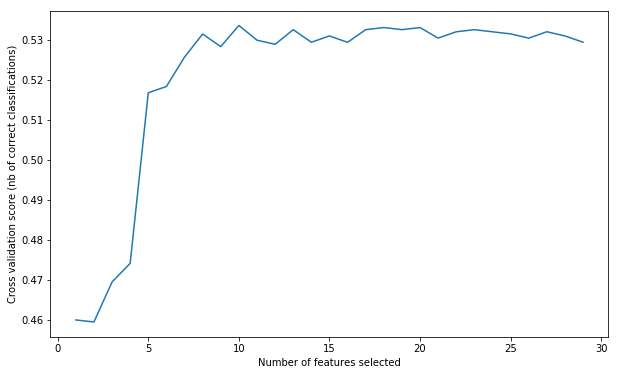

In [117]:
df_copy = df.copy()
df_copy = code_FTR(df_copy) 

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

X = df_copy[X.columns[rfecv.support_]]
classifier = LogisticRegression()
scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [118]:
def remove_outliers(column):
    elements = numpy.array(df[column])
    
    mean = numpy.mean(elements, axis=0)
    sd = numpy.std(elements, axis=0)
    
    final_list = [x for x in numpy.array(df[column]) if (x > mean - 4 * sd)]
    return [x for x in final_list if (x < mean + 4 * sd)]

def remove_outliers_for_FTR(df_copy):
    df_copy_Home = df_copy[df_copy['FTR'].isin(['H'])]
    df_copy_Draw = df_copy[df_copy['FTR'].isin(['D'])]
    df_copy_Away = df_copy[df_copy['FTR'].isin(['A'])]

    columns = ['DP','GD']

    for c in columns :
        df_copy_Home = df_copy_Home[df_copy_Home[c].isin(remove_outliers(c))]
        df_copy_Draw = df_copy_Draw[df_copy_Draw[c].isin(remove_outliers(c))]
        df_copy_Away = df_copy_Away[df_copy_Away[c].isin(remove_outliers(c))]
    
    filepaths = [df_copy_Home,df_copy_Draw,df_copy_Away]
    return pd.concat(filepaths,ignore_index=True,sort = True)

In [119]:
df_copy = df.copy()
df_copy = remove_outliers_for_FTR(df_copy)
df_copy = code_FTR(df_copy)  

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

X = df_copy[X.columns[rfecv.support_]]
classifier = LogisticRegression()
scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

LogisticRegression average accuracy is 0.531


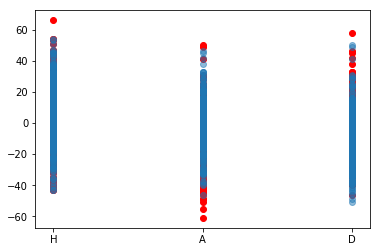

In [120]:
plt.scatter(df['FTR'], df['DP'], color= 'red')
plt.scatter(df_copy['FTR'], df_copy['DP'],alpha=0.5)
plt.show()

In [126]:
def discretize(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    discrete = np.digitize(data, cutoffs, right=True)
    return discrete, cutoffs

df_copy = df.copy()
df_copy = code_FTR(df_copy) 

size_of_interval = [20,40,60,80,100,120,140,160,200]

for internal in size_of_interval:
    print("interval size ",internal)
    df_copy.GD,b=discretize(df_copy.GD,internal)
    df_copy.AOD,b=discretize(df_copy.DP,internal)

    X = df_copy[df_copy.columns.difference(['FTR'])]
    y = df_copy['FTR']

    rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
    rfecv.fit(X, y)

    print("Optimal number of features: %d" % rfecv.n_features_)
    print('Selected features: %s' % list(X.columns[rfecv.support_]))

    X = df_copy[X.columns[rfecv.support_]]
    classifier = LogisticRegression()
    scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
    print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

interval size  20
Optimal number of features: 6
Selected features: ['DOD', 'GD', 'HGS', 'HOD', 'LFD', 'LSTPD']
LogisticRegression average accuracy is 0.529
interval size  40
Optimal number of features: 22
Selected features: ['AGD', 'AGS', 'ALF', 'AOD', 'AP', 'AwayTeam', 'DOD', 'DP', 'GD', 'HGD', 'HGL', 'HGS', 'HLF', 'HOD', 'HP', 'HomeTeam', 'LFD', 'LSTPA', 'LSTPD', 'LSTPH', 'MW', 'Month']
LogisticRegression average accuracy is 0.529
interval size  60
Optimal number of features: 10
Selected features: ['AGD', 'DOD', 'GD', 'HGS', 'HLF', 'HOD', 'HomeTeam', 'LFD', 'LSTPD', 'MW']
LogisticRegression average accuracy is 0.536
interval size  80
Optimal number of features: 10
Selected features: ['AGS', 'ALF', 'DOD', 'HGS', 'HLF', 'HOD', 'HomeTeam', 'LFD', 'LSTPA', 'LSTPD']
LogisticRegression average accuracy is 0.536
interval size  100
Optimal number of features: 10
Selected features: ['AGD', 'DOD', 'HGS', 'HLF', 'HOD', 'HomeTeam', 'LFD', 'LSTPA', 'LSTPD', 'MW']
LogisticRegression average accura

In [134]:
df_copy = df.copy()
df_copy = code_FTR(df_copy)  

df_copy.GD,b=discretize(df_copy.GD,100)
df_copy.AOD,b=discretize(df_copy.DP,100)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

X = df_copy[X.columns[rfecv.support_]]

param_grid = [
  {'penalty': ['l2'], 'solver': [ 'newton-cg','lbfgs', 'sag', 'saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l2'], 'solver': ['liblinear'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l1'], 'solver': ['saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
 ]

model_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=10)
model_lr.fit(X, y)
clf = model_lr.best_estimator_
print('The best found score and model:')
print (model_lr.best_score_, model_lr.best_params_) 

The best found score and model:
0.541578947368421 {'C': 0.01, 'class_weight': None, 'multi_class': 'multinomial', 'solver': 'saga', 'penalty': 'l1'}


In [135]:
df_copy = df.copy()
df_copy = code_FTR(df_copy)  

df_copy.GD,b=discretize(df_copy.GD,100)
df_copy.AOD,b=discretize(df_copy.DP,100)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

X = df_copy[X.columns[rfecv.support_]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


classifier = LogisticRegression(C= 0.01,penalty= 'l1',class_weight= None, multi_class= 'multinomial',solver= 'saga') 
scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_test, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_test, y_pred))

LogisticRegression average accuracy is 0.542

 Confusion matrix: 
[[217  51   0]
 [ 85  96   0]
 [ 74  47   0]] 

Classification report: 
             precision    recall  f1-score   support

          0       0.58      0.81      0.67       268
          1       0.49      0.53      0.51       181
          2       0.00      0.00      0.00       121

avg / total       0.43      0.55      0.48       570



<module 'matplotlib.pyplot' from 'C:\\Users\\Grzesiek\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

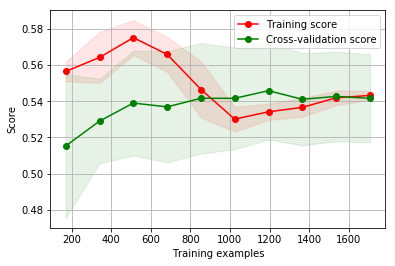

In [136]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=10, scoring='accuracy', obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

plot_learning_curve( LogisticRegression(C= 0.01,penalty= 'l1',class_weight= None, multi_class= 'multinomial',solver= 'saga'), X, y )

In [139]:
df_copy = df.copy()
df_copy = code_string_values(df_copy)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('xgBoost average accuracy is: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))

xgBoost average accuracy is: 52.2807


In [171]:
df_copy = df.copy()
df_copy = code_string_values(df_copy)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

model = xgb.XGBClassifier()
kfold = KFold(n_splits=10)
results = cross_val_score(model, X, y, cv=kfold)
print("xgBoost average accuracy is: %.2f%%" % (results.mean()*100))

xgBoost average accuracy is: 53.26%


In [172]:
df_copy = df.copy()
df_copy = code_string_values(df_copy)
df_copy = normalize(df_copy)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

model = xgb.XGBClassifier()
kfold = KFold(n_splits=10)
results = cross_val_score(model, X, y, cv=kfold)
print("xgBoost average accuracy is: %.2f%%" % (results.mean()*100))

xgBoost average accuracy is: 53.26%


In [173]:
df_copy = df.copy()
df_copy = code_string_values(df_copy)
df_copy = normalize(df_copy)
df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

model = xgb.XGBClassifier()
kfold = KFold(n_splits=10)
results = cross_val_score(model, X, y, cv=kfold)
print("xgBoost average accuracy is: %.2f%%" % (results.mean()*100))

xgBoost average accuracy is: 52.21%


In [152]:
df_copy = df.copy()
df_copy = code_string_values(df_copy)
df_copy = normalize(df_copy)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

model = xgb.XGBClassifier()
X = get_RFE_features(model,X,y,df_copy,5)

kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, y, cv=kfold)
print("xgBoost average accuracy is: %.2f%%" % (results.mean()*100))

[ 1  1 11 17 21  1 16  9  1 12 20  7  4  5  3  2 13 18 24  1 14  8 19 15
  6 10 22 25 23] 

Index(['AF', 'AGD', 'AOD', 'DOD', 'HOD'], dtype='object') 

xgBoost average accuracy is: 51.84% (5.01%)


Optimal number of features: 29
Selected features: ['AF', 'AGD', 'AGL', 'AGS', 'ALF', 'AOD', 'AP', 'AwayTeam', 'DOD', 'DP', 'DPB', 'Day', 'DaysFromToday', 'GD', 'HF', 'HGD', 'HGL', 'HGS', 'HLF', 'HOD', 'HP', 'HomeTeam', 'LFD', 'LSTPA', 'LSTPD', 'LSTPH', 'MW', 'Month', 'Year']
XGBClassifier average accuracy is 0.533


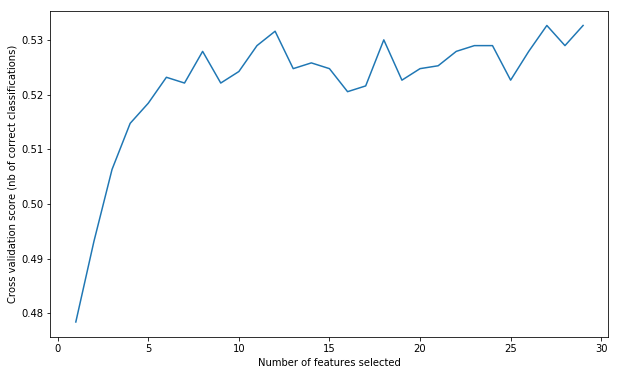

In [166]:
df_copy = df.copy()
df_copy = code_string_values(df_copy)
df_copy = normalize(df_copy)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

rfecv = RFECV(estimator=xgb.XGBClassifier(), step=1, cv=kfold, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

X = df_copy[X.columns[rfecv.support_]]
classifier = xgb.XGBClassifier()
scores_accuracy = cross_val_score(classifier, X, y, cv=kfold, scoring='accuracy')
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [167]:
df_copy = df.copy()
df_copy = remove_outliers_for_FTR(df_copy)
df_copy = code_string_values(df_copy)
df_copy = normalize(df_copy)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']
kfold = KFold(n_splits=10, random_state=7)
rfecv = RFECV(estimator=xgb.XGBClassifier(), step=1, cv=kfold, scoring='accuracy')
rfecv.fit(X, y)

X = df_copy[X.columns[rfecv.support_]]
classifier = xgb.XGBClassifier()
scores_accuracy = cross_val_score(classifier, X, y, cv=kfold, scoring='accuracy')
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

XGBClassifier average accuracy is 0.374


In [156]:
df_copy = df.copy()
df_copy = remove_outliers_for_FTR(df_copy)
df_copy = code_string_values(df_copy)
df_copy = normalize(df_copy)

size_of_interval = [20,40,60,80,100,120,140,160,200]

for internal in size_of_interval:
    print("interval size ",internal)
    df_copy.GD,b=discretize(df_copy.GD,internal)
    df_copy.AOD,b=discretize(df_copy.DP,internal)

    X = df_copy[df_copy.columns.difference(['FTR'])]
    y = df_copy['FTR']

    rfecv = RFECV(estimator=xgb.XGBClassifier(), step=1, cv=kfold, scoring='accuracy')
    rfecv.fit(X, y)

    print("Optimal number of features: %d" % rfecv.n_features_)
    print('Selected features: %s' % list(X.columns[rfecv.support_]))
    
    X = df_copy[X.columns[rfecv.support_]]
    classifier = xgb.XGBClassifier()
    scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
    print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

interval size  20
Optimal number of features: 20
Selected features: ['AF', 'AGD', 'AGL', 'AGS', 'AwayTeam', 'DOD', 'DP', 'Day', 'DaysFromToday', 'GD', 'HF', 'HGD', 'HGL', 'HOD', 'HP', 'HomeTeam', 'LFD', 'LSTPD', 'LSTPH', 'Year']
XGBClassifier average accuracy is 0.526
interval size  40
Optimal number of features: 19
Selected features: ['AF', 'AGD', 'AGL', 'AGS', 'AOD', 'AwayTeam', 'DOD', 'Day', 'DaysFromToday', 'GD', 'HF', 'HGD', 'HGL', 'HGS', 'HOD', 'HomeTeam', 'LSTPD', 'LSTPH', 'Year']
XGBClassifier average accuracy is 0.530
interval size  60
Optimal number of features: 20
Selected features: ['AF', 'AGD', 'AGL', 'AGS', 'AOD', 'AwayTeam', 'DOD', 'Day', 'DaysFromToday', 'GD', 'HF', 'HGD', 'HGL', 'HGS', 'HOD', 'HomeTeam', 'LFD', 'LSTPD', 'LSTPH', 'Year']
XGBClassifier average accuracy is 0.530
interval size  80
Optimal number of features: 23
Selected features: ['AF', 'AGD', 'AGL', 'AGS', 'AOD', 'AwayTeam', 'DOD', 'DPB', 'Day', 'DaysFromToday', 'GD', 'HF', 'HGD', 'HGL', 'HGS', 'HOD', 'HP

In [169]:
df_copy = df.copy()
df_copy = code_string_values(df_copy)
df_copy = normalize(df_copy)


df_copy.GD,b=discretize(df_copy.GD,160)
df_copy.AOD,b=discretize(df_copy.DP,160)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

rfecv = RFECV(estimator=xgb.XGBClassifier(), step=1, cv=kfold, scoring='accuracy')
rfecv.fit(X, y)
    
X = df_copy[X.columns[rfecv.support_]]
classifier = xgb.XGBClassifier()

fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores_accuracy = cross_val_score(classifier, X, y, cv = kfold, scoring = 'accuracy',fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())

[0]	validation_0-merror:0.453684
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.450526
[2]	validation_0-merror:0.446316
[3]	validation_0-merror:0.445263
[4]	validation_0-merror:0.440526
[5]	validation_0-merror:0.441579
[6]	validation_0-merror:0.441053
[7]	validation_0-merror:0.44
[8]	validation_0-merror:0.436316
[9]	validation_0-merror:0.437895
[10]	validation_0-merror:0.438421
[11]	validation_0-merror:0.435789
[12]	validation_0-merror:0.437895
[13]	validation_0-merror:0.436316
[14]	validation_0-merror:0.436316
[15]	validation_0-merror:0.433158
[16]	validation_0-merror:0.433684
[17]	validation_0-merror:0.431579
[18]	validation_0-merror:0.431053
[19]	validation_0-merror:0.432105
[20]	validation_0-merror:0.429474
[21]	validation_0-merror:0.427895
[22]	validation_0-merror:0.422105
[23]	validation_0-merror:0.424211
[24]	validation_0-merror:0.420526
[25]	validation_0-merror:0.419474
[26]	validation_0-merror:0.416316
[27]	validation_0-merror:0.41

[38]	validation_0-merror:0.388421
[39]	validation_0-merror:0.386316
[40]	validation_0-merror:0.386316
[41]	validation_0-merror:0.385263
[42]	validation_0-merror:0.385263
[43]	validation_0-merror:0.383684
[44]	validation_0-merror:0.381053
[45]	validation_0-merror:0.38
[46]	validation_0-merror:0.38
[47]	validation_0-merror:0.378947
[48]	validation_0-merror:0.381053
[49]	validation_0-merror:0.380526
[50]	validation_0-merror:0.376842
[51]	validation_0-merror:0.377368
[52]	validation_0-merror:0.377368
[53]	validation_0-merror:0.371053
[54]	validation_0-merror:0.368947
[55]	validation_0-merror:0.371053
[56]	validation_0-merror:0.368421
[57]	validation_0-merror:0.366316
[58]	validation_0-merror:0.365789
[59]	validation_0-merror:0.364737
[60]	validation_0-merror:0.363158
[61]	validation_0-merror:0.363684
[62]	validation_0-merror:0.363158
[63]	validation_0-merror:0.360526
[64]	validation_0-merror:0.356316
[65]	validation_0-merror:0.355789
[66]	validation_0-merror:0.357895
[67]	validation_0-merr

[78]	validation_0-merror:0.348421
[79]	validation_0-merror:0.349474
[80]	validation_0-merror:0.348947
[81]	validation_0-merror:0.346316
[82]	validation_0-merror:0.345263
[83]	validation_0-merror:0.344737
[84]	validation_0-merror:0.343158
[85]	validation_0-merror:0.343684
[86]	validation_0-merror:0.343158
[87]	validation_0-merror:0.34
[88]	validation_0-merror:0.339474
[89]	validation_0-merror:0.337368
[90]	validation_0-merror:0.337368
[91]	validation_0-merror:0.333684
[92]	validation_0-merror:0.332105
[93]	validation_0-merror:0.328947
[94]	validation_0-merror:0.33
[95]	validation_0-merror:0.329474
[96]	validation_0-merror:0.324737
[97]	validation_0-merror:0.323684
[98]	validation_0-merror:0.323684
[99]	validation_0-merror:0.321579
[0]	validation_0-merror:0.451579
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.453684
[2]	validation_0-merror:0.447368
[3]	validation_0-merror:0.442105
[4]	validation_0-merror:0.441053
[5]	validation_0-merror:0.43

[16]	validation_0-merror:0.421053
[17]	validation_0-merror:0.417895
[18]	validation_0-merror:0.42
[19]	validation_0-merror:0.42
[20]	validation_0-merror:0.420526
[21]	validation_0-merror:0.418947
[22]	validation_0-merror:0.42
[23]	validation_0-merror:0.417895
[24]	validation_0-merror:0.415263
[25]	validation_0-merror:0.411579
[26]	validation_0-merror:0.410526
[27]	validation_0-merror:0.408947
[28]	validation_0-merror:0.411053
[29]	validation_0-merror:0.411053
[30]	validation_0-merror:0.41
[31]	validation_0-merror:0.411053
[32]	validation_0-merror:0.407368
[33]	validation_0-merror:0.405789
[34]	validation_0-merror:0.403158
[35]	validation_0-merror:0.4
[36]	validation_0-merror:0.398947
[37]	validation_0-merror:0.397895
[38]	validation_0-merror:0.396316
[39]	validation_0-merror:0.397368
[40]	validation_0-merror:0.396842
[41]	validation_0-merror:0.394211
[42]	validation_0-merror:0.392105
[43]	validation_0-merror:0.393158
[44]	validation_0-merror:0.391053
[45]	validation_0-merror:0.391053
[

[56]	validation_0-merror:0.373158
[57]	validation_0-merror:0.371579
[58]	validation_0-merror:0.368421
[59]	validation_0-merror:0.366842
[60]	validation_0-merror:0.367895
[61]	validation_0-merror:0.366316
[62]	validation_0-merror:0.364211
[63]	validation_0-merror:0.363158
[64]	validation_0-merror:0.361053
[65]	validation_0-merror:0.361579
[66]	validation_0-merror:0.361579
[67]	validation_0-merror:0.358421
[68]	validation_0-merror:0.356842
[69]	validation_0-merror:0.361579
[70]	validation_0-merror:0.362632
[71]	validation_0-merror:0.361579
[72]	validation_0-merror:0.358421
[73]	validation_0-merror:0.357895
[74]	validation_0-merror:0.356316
[75]	validation_0-merror:0.354737
[76]	validation_0-merror:0.353158
[77]	validation_0-merror:0.352632
[78]	validation_0-merror:0.35
[79]	validation_0-merror:0.346842
[80]	validation_0-merror:0.346316
[81]	validation_0-merror:0.344737
[82]	validation_0-merror:0.340526
[83]	validation_0-merror:0.337895
[84]	validation_0-merror:0.338421
[85]	validation_0-

In [22]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

with HiddenPrints():
    grid_obj = GridSearchCV(clf,
                            param_grid=parameters,
                             fit_params={'early_stopping_rounds':20,\
                             'eval_set':[(X,y)]},cv=5)
    grid_obj.fit(X_train, y_train)
    tree_model = grid_obj.best_estimator_

print (grid_obj.best_score_, grid_obj.best_params_) 

0.540377358490566 {'min_child_weight': 10, 'max_depth': 3, 'subsample': 1.0, 'gamma': 2, 'colsample_bytree': 1.0}


In [115]:
clf = xgb.XGBClassifier(subsample= 1.0, gamma= 2, min_child_weight= 10, colsample_bytree= 1.0, max_depth= 3,learning_rate=0.3)

eval_set = [(X_test, y_test)]
clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="merror", eval_set=eval_set, verbose=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy of xgBoost on train set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))
print('Accuracy of xgBoost on test set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))

y_pred = clf.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

[0]	validation_0-merror:0.471002
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.463972
[2]	validation_0-merror:0.465729
[3]	validation_0-merror:0.463972
[4]	validation_0-merror:0.455185
[5]	validation_0-merror:0.465729
[6]	validation_0-merror:0.455185
[7]	validation_0-merror:0.460457
[8]	validation_0-merror:0.458699
[9]	validation_0-merror:0.45167
[10]	validation_0-merror:0.453427
[11]	validation_0-merror:0.45167
[12]	validation_0-merror:0.460457
[13]	validation_0-merror:0.462214
[14]	validation_0-merror:0.465729
[15]	validation_0-merror:0.472759
[16]	validation_0-merror:0.469244
[17]	validation_0-merror:0.469244
[18]	validation_0-merror:0.465729
[19]	validation_0-merror:0.462214
[20]	validation_0-merror:0.467487
[21]	validation_0-merror:0.465729
[22]	validation_0-merror:0.465729
[23]	validation_0-merror:0.460457
[24]	validation_0-merror:0.462214
[25]	validation_0-merror:0.462214
[26]	validation_0-merror:0.462214
[27]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-merror:0.455849	validation_1-merror:0.476274
[1]	validation_0-merror:0.426415	validation_1-merror:0.453427
[2]	validation_0-merror:0.407547	validation_1-merror:0.425308
[3]	validation_0-merror:0.397736	validation_1-merror:0.425308
[4]	validation_0-merror:0.388679	validation_1-merror:0.42355
[5]	validation_0-merror:0.394717	validation_1-merror:0.42355
[6]	validation_0-merror:0.396226	validation_1-merror:0.418278
[7]	validation_0-merror:0.396981	validation_1-merror:0.418278
[8]	validation_0-merror:0.395472	validation_1-merror:0.425308
[9]	validation_0-merror:0.394717	validation_1-merror:0.428822
[10]	validation_0-merror:0.392453	validation_1-merror:0.442882
[11]	validation_0-merror:0.393208	validation_1-merror:0.44464
[12]	validation_0-merror:0.390189	validation_1-merror:0.441125
[13]	validation_0-merror:0.391698	validation_1-merror:0.441125
[14]	validation_0-merror:0.391698	validation_1-merror:0.441125
[15]	validation_0-merror:0.386415	validation_1-merror:0.439367
[16]	

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


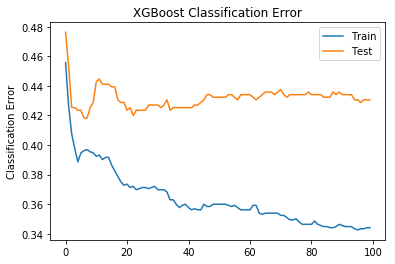

In [117]:
df_copy = df.copy()

df_copy = remove_outliers_for_FTR(df_copy) 
df_copy = code_string_values(df_copy)
df_copy = code_FTR(df_copy)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# fit model no training data
model = xgb.XGBClassifier(subsample= 0.9, gamma= 4, min_child_weight= 1, colsample_bytree= 0.9, max_depth= 3,learning_rate=0.35)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
print('Accuracy of xgBoost on train set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))
print('Accuracy of xgBoost on test set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))
predictions = [round(value) for value in y_pred]

results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()